In [1]:
import tensorflow as tf
import PIL
from PIL import Image
from scipy.misc import imread, imshow,imresize
from glob import glob
from itertools import cycle,zip_longest
import numpy as np
import matplotlib.pyplot as plt
import imageio
import random
import os
from tensorflow.contrib import slim
import time
import sys
sys.path.insert(0, '/home/ubuntu/workspace/models/research/slim/')
from nets.resnet_v1 import resnet_v1,resnet_v1_101,resnet_arg_scope
from preprocessing import inception_preprocessing, vgg_preprocessing
from datasets import dataset_utils

In [ ]:
url = "http://download.tensorflow.org/models/resnet_v1_101_2016_08_28.tar.gz"

if not tf.gfile.Exists(checkpoints_dir):
    tf.gfile.MakeDirs(checkpoints_dir)

dataset_utils.download_and_uncompress_tarball(url, checkpoints_dir)

In [2]:
random.seed(42)
tf.set_random_seed(42)
def grouper(n, iterable, fillvalue=None):
  args = [iter(iterable)]*n
  return zip_longest(*args, fillvalue=fillvalue)
height_image = resnet_v1.default_image_size
width_image = resnet_v1.default_image_size
print(height_image)
data_dir = "/home/ubuntu/project/data/"
checkpoints_dir = '/tmp/checkpoints'

224


In [3]:
def get_images(data_dir, data_type, batch_size=10):
  height = height_image
  width = width_image
  if(data_type == 1):
    data_dir = data_dir +"Train/"
  elif(data_type == 2):
    data_dir = data_dir +"Val/"
  elif(data_type == 3):
    data_dir = data_dir +"Test/"
  input_files_positive = glob(data_dir + "Positive/*.jpg")
  input_files_negative = glob(data_dir + "Negative/*.jpg")
  input_files_neutral = glob(data_dir + "Neutral/*.jpg")
  #input_files_positive = glob(data_dir + "daisy/*.jpg")
  #input_files_negative = glob(data_dir + "roses/*.jpg")
  #input_files_neutral = glob(data_dir + "tulips/*.jpg")
  input_files = input_files_positive + input_files_negative + input_files_neutral
  labels = [np.array([0,0,1])]*len(input_files_positive) + [np.array([0,1,0])]*len(input_files_negative) + [np.array([1,0,0])]*len(input_files_neutral)
  label_files = list(zip(input_files,labels))
  label_files = random.sample(label_files,len(label_files))
  label_files_infinite = cycle(label_files)

  label_files_grouped = grouper(batch_size,label_files_infinite)
  while 1:
    image_names,labels = zip(*next(label_files_grouped))
    
    dx = height_image
    dy = width_image
    
    image_data = [Image.open(fname) for fname in image_names]
    
    if(data_type == 1):
        resized_small = [image.resize((256,256),PIL.Image.ANTIALIAS) if (image.size[0] < 256 or image.size[1] < 256) else image for image in image_data]
        #images = [image.resize((256,256),PIL.Image.ANTIALIAS) for image in image_data]
        images = [image.resize((356,356),PIL.Image.ANTIALIAS) if (image.size[0] > 300 or image.size[1] > 300) else image for image in resized_small]
    
        images_crop = []
        for image in images:
            x = random.randint(0, image.size[0]-dx-1)
            y = random.randint(0, image.size[1]-dy-1) 
            images_crop.append(image.crop((x,y, x+dx, y+dy)))
    
        pil_images = [np.fliplr(image) if np.random.random() > 0.5 else image for image in images_crop]
    elif(data_type == 2):
        pil_images = [image.resize((dx,dy),PIL.Image.ANTIALIAS)  for image in image_data]
    
    image_files = [np.array(np_image) for np_image in pil_images]
    
    yield zip(image_files,list(labels))


In [12]:
a = get_images(data_dir,1,15)

3
15


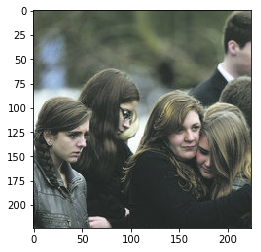

In [13]:
images, labels = map(list, zip(*next(a)))
print(labels[0].size)
print(len(images))
plt.imshow(images[0])
plt.show()


In [15]:
#total input dataset
total_num_images_training = 3630
total_num_images_validation = 2065

#data segmentation
num_epochs = 5 #hp 1
batch_size = 50 #hp 2

#learning rate
initial_learning_rate = 0.001 #hp 3
num_epochs_before_decay = 60
learning_rate_decay_iterations = 15 #hp 4

#dropout
keep_prob_val = 0.9 #hp 5
keep_prob_val_data = 0.96 #hp 5

#size of each training/validation iteration
num_batches_per_epoch_training = int(total_num_images_training / batch_size)
num_batches_per_epoch_validaton = int(total_num_images_validation / batch_size)

#data feeder generators
training_generator = get_images(data_dir,1,batch_size)
validation_generator = get_images(data_dir,2,batch_size)
test_generator = get_images(data_dir,2,batch_size)

In [16]:
def feed_dict(batch_size,generator, epoch, use_dropout):
    
    lr = initial_learning_rate

    keep_prob_per = 1
    keep_prob_data_per = 1

    if use_dropout == 1:
        keep_prob_per = keep_prob_val
        keep_prob_data_per = keep_prob_val_data

    imgs, lbls = map(list, zip(*next(generator)))

    if(epoch >= num_epochs_before_decay and epoch % learning_rate_decay_iterations == 0):
        lr = 0.001*(10**(-epoch/100))

    return {images: imgs, labels: lbls,learning_rate: lr, keep_prob: keep_prob_per, keep_prob_data: keep_prob_data_per}

In [17]:
tf.reset_default_graph()

images = tf.placeholder(tf.float32,shape=[None,height_image,width_image,3])
labels = tf.placeholder(tf.float32,shape=[None,3])
learning_rate = tf.placeholder(tf.float32,shape=[])
keep_prob = tf.placeholder(tf.float32,shape=[])
keep_prob_data = tf.placeholder(tf.float32,shape=[])

with slim.arg_scope(resnet_arg_scope()):
    logits_drop_1 = tf.contrib.layers.dropout(images, keep_prob_data)
    resnet_logits, end_points = resnet_v1_101(logits_drop_1, num_classes=3, global_pool=True, is_training=True)
    
checkpoint_exclude_scopes=["resnet_v1_101/logits"]
#checkpoint_exclude_scopes=[]
exclusions = checkpoint_exclude_scopes
#review code!
variables_to_restore = []
for var in slim.get_model_variables():
    excluded = False
    for exclusion in exclusions:
        if var.op.name.startswith(exclusion):
            excluded = True
            break
    if not excluded:
        variables_to_restore.append(var)
#variables_to_restore = slim.get_variables_to_restore(exclude = checkpoint_exclude_scopes)
saver = tf.train.Saver(variables_to_restore)

final_shape = end_points['global_pool'].get_shape()
flatten_size = int(final_shape[1]*final_shape[2]*final_shape[3])
flatten = tf.reshape(end_points['global_pool'], [-1, flatten_size])
#introduce dropout for resnet final FC layer
logits_drop = tf.contrib.layers.dropout(flatten, keep_prob)
#introduce final FC layer to map output of resnet 1000 to 3 classes
logits = tf.contrib.layers.fully_connected(logits_drop, 3)

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=logits, logits=resnet_logits))
correct_prediction = tf.equal(tf.argmax(logits,1), tf.argmax(labels,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = slim.learning.create_train_op(cross_entropy, optimizer)


with tf.Session() as sess:
 
  saver.restore(sess,os.path.join(checkpoints_dir, 'resnet_v1_101.ckpt'))
  sess.run(tf.initialize_all_variables())
  
  total_loss_val = 0
  total_val_loss_val = 0
  total_train_accuracy = 0
  total_val_accuracy = 0
  best_accuracy = 0
  avg_training_acc = 0
  avg_val_acc = 0
  start_time_per_epoch = 0
  time_elapsed_eval_per_epoch = 0
  time_elapsed_training_per_epoch = 0
  overall_training_time = 0
  
  overall_training_time = time.time()
  for i in range(num_epochs):
    
    best_acc_file = open('/home/ubuntu/project/L44_Mini_Project/data_dir/resnet_accuracy/best_accuracy.txt',"a") 
    all_acc_file = open('/home/ubuntu/project/L44_Mini_Project/data_dir/resnet_accuracy/all_accuracy.txt',"a") 
    
    start_time_per_epoch = time.time()
    for j in range(num_batches_per_epoch_training):
      print("Epoch %s, Batch %s" % (i,j))
      _,training_loss = sess.run([train_op, cross_entropy],feed_dict=feed_dict(batch_size,training_generator,i,True))
      train_accuracy = accuracy.eval(feed_dict=feed_dict(batch_size,training_generator,i,True))
      total_loss_val = total_loss_val + training_loss
      total_train_accuracy = total_train_accuracy + train_accuracy
    avg_training_acc = total_train_accuracy/num_batches_per_epoch_training
    print("--------------------------------------------------------------------")
    print("Epoch %s: training accuracy %s, training loss %s" % (i,avg_training_acc,total_loss_val))
    time_elapsed_training_per_epoch = time.time() - start_time_per_epoch
    for _ in range(num_batches_per_epoch_validaton):
      validation_loss = sess.run([cross_entropy],feed_dict=feed_dict(batch_size,validation_generator,i,False))
      total_val_loss_val = total_val_loss_val + validation_loss[0]
      validation_accuracy = accuracy.eval(feed_dict=feed_dict(batch_size,validation_generator,i,False))
      total_val_accuracy = total_val_accuracy + validation_accuracy
    avg_val_acc = total_val_accuracy/num_batches_per_epoch_validaton
    print("Epoch %s: validation accuracy %s, validation loss %s" % (i,avg_val_acc, total_val_loss_val))
    print("--------------------------------------------------------------------")
    time_elapsed_eval_per_epoch = time.time() - start_time_per_epoch - time_elapsed_training_per_epoch
    all_acc_file.write("%s %s %s %s %s %s %s\n" % (i, total_loss_val, total_val_loss_val, avg_training_acc, avg_val_acc, time_elapsed_training_per_epoch, time_elapsed_eval_per_epoch))
   
    #store model at best accuracy
    if avg_val_acc > best_accuracy:
      best_acc_file.write("Epoch %s: " % (i))
      best_acc_file.write("Best validation accuracy: %s\n" % (avg_val_acc))
      best_accuracy = avg_val_acc
      best_model_path = saver.save(sess, '/home/ubuntu/project/best_models/resnet/')  
    
    total_loss_val = 0
    total_val_loss_val = 0
    total_train_accuracy = 0
    total_val_accuracy = 0
    avg_training_acc = 0
    avg_val_acc = 0
    best_model_path = ""
    start_time = 0
    time_elapsed_eval = 0
    time_elapsed_training = 0
    
    best_acc_file.close()
    all_acc_file.close()
    
  overall_training_time = time.time() - overall_training_time
  print("Training time: %s" % overall_training_time)
    

INFO:tensorflow:Restoring parameters from /tmp/checkpoints/resnet_v1_101.ckpt
Epoch 0, Batch 0
Epoch 0, Batch 1
Epoch 0, Batch 2
Epoch 0, Batch 3
Epoch 0, Batch 4
Epoch 0, Batch 5


KeyboardInterrupt: 